In [2]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

In [3]:
dataset = load_dataset("microsoft/ms_marco", "v1.1")

In [4]:
dataset["train"][0]

{'answers': ['Results-Based Accountability is a disciplined way of thinking and taking action that communities can use to improve the lives of children, youth, families, adults and the community as a whole.'],
 'passages': {'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  'passage_text': ["Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.",
   "The Reserve Bank of Australia (RBA) came into being on 14 January 1960 as Australia 's central bank and banknote issuing authority, when the Reserve Bank Act 1959 removed the central banking functions from the C

In [4]:
def prepare_data(examples):
    queries = []
    passages = []
    labels = []
    
    for query, passages_dict in zip(examples["query"], examples["passages"]):
        for passage, label in zip(passages_dict["passage_text"], passages_dict["is_selected"]):
            queries.append(query)
            passages.append(passage)
            labels.append(label)
            
    return {"query": queries, "passage": passages, "label": labels}

In [5]:
dataset_processed = dataset.map(prepare_data, batched=True, remove_columns=dataset['train'].column_names)

In [6]:
dataset_processed

DatasetDict({
    validation: Dataset({
        features: ['query', 'passage', 'label'],
        num_rows: 82360
    })
    train: Dataset({
        features: ['query', 'passage', 'label'],
        num_rows: 676193
    })
    test: Dataset({
        features: ['query', 'passage', 'label'],
        num_rows: 79176
    })
})

In [8]:
dataset_processed["train"][0], dataset_processed["train"][1]

({'query': 'what is rba',
  'passage': "Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.",
  'label': 0},
 {'query': 'what is rba',
  'passage': "The Reserve Bank of Australia (RBA) came into being on 14 January 1960 as Australia 's central bank and banknote issuing authority, when the Reserve Bank Act 1959 removed the central banking functions from the Commonwealth Bank. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [10]:
def count_tokens_batched(examples):
    query_tokenized = tokenizer(examples["query"], return_tensors=None)
    query_counts = [len(seq) for seq in query_tokenized["input_ids"]]

    passage_tokenized = tokenizer(examples["passage"], return_tensors=None)
    passage_counts = [len(seq) for seq in passage_tokenized["input_ids"]]
    
    return {"query_token_counts": query_counts, "passage_token_counts": passage_counts}

In [11]:
tokenized_dataset = dataset_processed["train"].map(
    count_tokens_batched,
    batched=True,
)

query_token_counts = tokenized_dataset["query_token_counts"]
passage_token_counts = tokenized_dataset["passage_token_counts"]

Запити (query):
Мінімальна кількість токенів: 4
Максимальна кількість токенів: 52
Середня кількість токенів: 9.17
Медіана: 9.00

Проходи (passage):
Мінімальна кількість токенів: 7
Максимальна кількість токенів: 387
Середня кількість токенів: 96.37
Медіана: 96.00


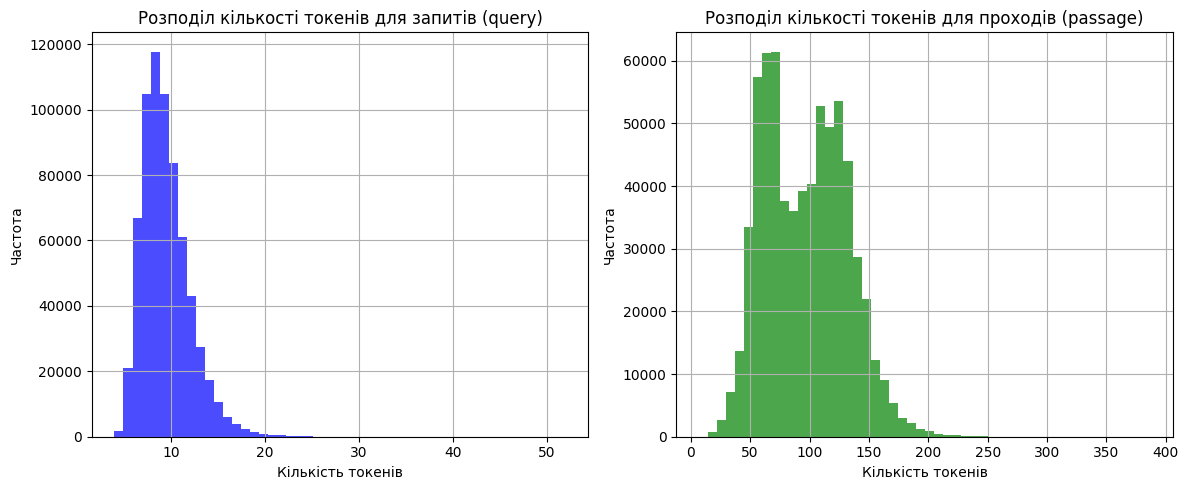

In [12]:
print("Запити (query):")
print(f"Мінімальна кількість токенів: {min(query_token_counts)}")
print(f"Максимальна кількість токенів: {max(query_token_counts)}")
print(f"Середня кількість токенів: {np.mean(query_token_counts):.2f}")
print(f"Медіана: {np.median(query_token_counts):.2f}")

print("\nПроходи (passage):")
print(f"Мінімальна кількість токенів: {min(passage_token_counts)}")
print(f"Максимальна кількість токенів: {max(passage_token_counts)}")
print(f"Середня кількість токенів: {np.mean(passage_token_counts):.2f}")
print(f"Медіана: {np.median(passage_token_counts):.2f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(query_token_counts, bins=50, color='blue', alpha=0.7)
plt.title("Розподіл кількості токенів для запитів (query)")
plt.xlabel("Кількість токенів")
plt.ylabel("Частота")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(passage_token_counts, bins=50, color='green', alpha=0.7)
plt.title("Розподіл кількості токенів для проходів (passage)")
plt.xlabel("Кількість токенів")
plt.ylabel("Частота")
plt.grid(True)

plt.tight_layout()

In [8]:
QUERY_MAX_LEN = 26
PASSAGE_MAX_LEN = 256

In [9]:
def tokenize_function(examples):
    query_tokens = tokenizer(examples["query"], padding="max_length", truncation=True, max_length=QUERY_MAX_LEN, return_tensors="tf")
    passage_tokens = tokenizer(examples["passage"], padding="max_length", truncation=True, max_length=PASSAGE_MAX_LEN, return_tensors="tf")
    
    return {
        "query_input_ids": query_tokens["input_ids"],
        "query_attention_mask": query_tokens["attention_mask"],
        "passage_input_ids": passage_tokens["input_ids"],
        "passage_attention_mask": passage_tokens["attention_mask"],
        "label_inputs": examples["label"]
    }

In [10]:
tokenized_dataset = dataset_processed.map(tokenize_function, batched=True, remove_columns=dataset_processed['train'].column_names)

In [16]:
tf.keras.saving.get_custom_objects().clear()

In [11]:
@tf.keras.utils.register_keras_serializable(package="MyModels")
class BertWrapper(tf.keras.layers.Layer):
    def __init__(self, model_name="bert-base-uncased", **kwargs):
        super().__init__(**kwargs)
        self.model_name = model_name
        self.model = TFBertModel.from_pretrained(model_name)
    
    def call(self, inputs, training=False):
        return self.model(inputs, training=training)

    def get_config(self):
        config = super().get_config()
        config.update({
            "model_name": self.model_name
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [12]:
@tf.keras.saving.register_keras_serializable(package="MyModels")
class BiEncoder(tf.keras.Model):
    def __init__(self, bert_model, projection_size=512, **kwargs):
        super().__init__(**kwargs)
        self.bert = bert_model
        self.bert.trainable = False
        self.projection_size = projection_size
        
        self.projection = tf.keras.layers.Dense(projection_size, activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-3))

        # Mean просто зберігає суму всіх значень (у цьому випадку loss) і ділить її на кількість оновлень.
        # Середній loss по всім batch
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

        # BinaryAccuracy підраховує кількість правильних передбачень і ділить її на загальну кількість передбачень.
        # Середній BinaryAccuracy по всім batch
        self.accuracy_metric = tf.keras.metrics.BinaryAccuracy(name="accuracy")
    
    def call(self, inputs, training=False):
        query_inputs = {
            "input_ids": inputs["query_input_ids"],
            "attention_mask": inputs["query_attention_mask"]
        }
        passage_inputs = {
            "input_ids": inputs["passage_input_ids"],
            "attention_mask": inputs["passage_attention_mask"]
        }

        # BERT використовується як попередньо натренована модель, яка вже навчилася розпізнавати структуру мови, граматику, семантику та відношення між словами. 
        # Його роль у цьому випадку – витягувати контекстуальні ембеддінги з тексту, які потім використовуються для fine-tuning.
        query_outputs = self.bert(query_inputs, training=False)
        passage_outputs = self.bert(passage_inputs, training=False)

        # Dense шар навчається таким чином, щоб перетворити вихідні ембеддінги з BERT (pooler_output) у простір меншої розмірності, де:
        # Для схожих пар (з позитивними мітками) ембеддінги наближаються один до одного (їх косинусна подібність має бути високою, близькою до 1).
        # Для несхожих пар (з негативними мітками) ембеддінги віддаляються (їх косинусна подібність має бути низькою, або нижчою за певний поріг).
        query_embeddings = self.projection(query_outputs.pooler_output, training=training)
        passage_embeddings = self.projection(passage_outputs.pooler_output, training=training)
        
        # Нормалізація зменшує вплив абсолютної величини векторів, що сприяє більш стабільному та ефективному навчання моделі.
        query_embeddings = tf.nn.l2_normalize(query_embeddings, axis=1)
        passage_embeddings = tf.nn.l2_normalize(passage_embeddings, axis=1)
        
        return query_embeddings, passage_embeddings
    
    # Цей метод обчислює косинусну подібність між ембедингами запитів і текстів. Значення близькі до 1 означають дуже подібні вектори, а значення близькі до 0 - дуже різні.
    def compute_similarity(self, query_embeddings, passage_embeddings):
        return tf.reduce_sum(query_embeddings * passage_embeddings, axis=1)
    
    def compute_loss(self, labels, similarities):
        labels = tf.cast(labels, tf.float32)
        similarities = tf.cast(similarities, tf.float32)
        
        # Обчислюємо (1 - similarity) - це дає 0, якщо подібність ідеальна (=1), і більше значення, якщо подібність менша.
        # Множимо на labels (0 або 1), щоб враховувати лише позитивні пари.
        positive_loss = tf.reduce_sum((1 - similarities) * labels)
        
        # Ми хочемо, щоб similarities було якнайменше.
        negative_loss = tf.reduce_sum(tf.maximum(0.0, similarities) * (1 - labels))
        
        # Середній loss по поточному batch
        batch_size = tf.cast(tf.shape(labels)[0], tf.float32)
        loss = (positive_loss + negative_loss) / batch_size
        
        return loss
    
    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            query_embeddings, passage_embeddings = self(x, training=True)
            similarities = self.compute_similarity(query_embeddings, passage_embeddings)
            loss = self.compute_loss(y, similarities)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.loss_tracker.update_state(loss)
        # Середній BinaryAccuracy по поточному batch
        self.accuracy_metric.update_state(y, tf.cast(similarities > 0.5, tf.float32))
        
        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.accuracy_metric.result()
        }

    def test_step(self, data):
        x, y = data
        
        query_embeddings, passage_embeddings = self(x, training=False)
        similarities = self.compute_similarity(query_embeddings, passage_embeddings)
        loss = self.compute_loss(y, similarities)
        
        self.loss_tracker.update_state(loss)
        self.accuracy_metric.update_state(y, tf.cast(similarities > 0.5, tf.float32))
        
        return {
            "loss": self.loss_tracker.result(), 
            "accuracy": self.accuracy_metric.result()
        }
    
    def get_query_embedding(self, input_ids, attention_mask):
        query_inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }

        outputs = self.bert(query_inputs, training=False)
        embedding = self.projection(outputs.pooler_output, training=False)

        return tf.nn.l2_normalize(embedding, axis=1)

    def get_passage_embedding(self, input_ids, attention_mask):
        passage_inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }
        
        outputs = self.bert(passage_inputs, training=False)
        embedding = self.projection(outputs.pooler_output, training=False)
        
        return tf.nn.l2_normalize(embedding, axis=1)
        
    # Цей метод дозволяє автоматично виводити метрики при навчанні через model.fit().
    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_metric]
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "bert_model": tf.keras.saving.serialize_keras_object(self.bert),
            "projection_size": self.projection_size
        })
        return config

    @classmethod
    def from_config(cls, config):
        bert_model = tf.keras.saving.deserialize_keras_object(config["bert_model"])
        return cls(
            bert_model=bert_model,
            projection_size=config["projection_size"]
        )

In [13]:
@tf.keras.saving.register_keras_serializable(package="MySchedules")
class CustomLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr=1e-3, decay_rate=0.9, decay_steps=2000, min_lr=1e-5):
        super().__init__()
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.min_lr = min_lr
        
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        decay_factor = self.decay_rate ** (step / self.decay_steps)
        lr = self.initial_lr * decay_factor
        lr = tf.maximum(lr, self.min_lr)
                
        return lr
    
    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "decay_rate": self.decay_rate,
            "decay_steps": self.decay_steps,
            "min_lr": self.min_lr
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [15]:
bert_wrapper = BertWrapper("bert-base-uncased")
bi_encoder = BiEncoder(bert_model=bert_wrapper, projection_size=512)
lr_schedule = CustomLearningRateSchedule()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [39]:
tf.keras.saving.get_custom_objects()

{'MyModels>BertWrapper': __main__.BertWrapper,
 'MyModels>BiEncoder': __main__.BiEncoder,
 'MySchedules>CustomLearningRateSchedule': __main__.CustomLearningRateSchedule}

In [16]:
BATCH_SIZE = 128
EPOCHS = 1

In [41]:
num_samples = int(0.5 * len(tokenized_dataset["train"]))
small_train_dataset = tokenized_dataset["train"].select(range(num_samples))

tf_train_dataset = small_train_dataset.to_tf_dataset(
    columns=[
        "query_input_ids", "query_attention_mask", "passage_input_ids", "passage_attention_mask", "label_inputs"
    ],
    label_cols="label_inputs",
    shuffle=True,
    batch_size=BATCH_SIZE)

In [42]:
tf_valid_dataset = tokenized_dataset["validation"].to_tf_dataset(
    columns=[
        "query_input_ids", "query_attention_mask", "passage_input_ids", "passage_attention_mask", "label_inputs"
    ],
    label_cols="label_inputs",
    shuffle=False,
    batch_size=BATCH_SIZE)

In [47]:
bi_encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))

In [48]:
history = bi_encoder.fit(tf_train_dataset, validation_data=tf_valid_dataset, epochs=EPOCHS, verbose=1)

2642/2642 [==============================] - 3370s 1s/step - loss: 0.1596 - accuracy: 0.8653 - val_loss: 0.1515 - val_accuracy: 0.8662


In [17]:
save_path = './semantic_search_model'

In [50]:
bi_encoder.save(
    save_path,
    save_format="tf",
    save_traces=True
)

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb457e72e40>, 140417947607376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb457e72e40>, 140417947607376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb457e73830>, 140417944471632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb457e73830>, 140417944471632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb457e72e40>, 140417947607376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(768, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb457e72e40>, 140417947607376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb457e73830>, 140417944471632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb457e73830>, 140417944471632), {}).


INFO:tensorflow:Assets written to: ./semantic_search_model/assets


INFO:tensorflow:Assets written to: ./semantic_search_model/assets


In [18]:
custom_objects = {
    "BertWrapper": BertWrapper,
    "BiEncoder": BiEncoder,
    "CustomLearningRateSchedule": CustomLearningRateSchedule,
    "Custom>Adam": tf.keras.optimizers.Adam
}

loaded_model = tf.keras.models.load_model(
    save_path,
    custom_objects=custom_objects
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [29]:
query_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=[
        "query_input_ids", "query_attention_mask"
    ],
    shuffle=False,
    batch_size=BATCH_SIZE)

In [30]:
for batch in query_dataset.take(1):
    query_emb = loaded_model.get_query_embedding(
        input_ids=batch["query_input_ids"],
        attention_mask=batch["query_attention_mask"]
    )
    print(query_emb)

tf.Tensor(
[[ 0.02479496 -0.01693601 -0.00658636 ... -0.00607428 -0.02764299
  -0.03300392]
 [ 0.02479496 -0.01693601 -0.00658636 ... -0.00607428 -0.02764299
  -0.03300392]
 [ 0.02479496 -0.01693601 -0.00658636 ... -0.00607428 -0.02764299
  -0.03300392]
 ...
 [ 0.05673377 -0.00784211 -0.02479044 ... -0.01192315 -0.06061027
  -0.04738678]
 [ 0.05673377 -0.00784211 -0.02479044 ... -0.01192315 -0.06061027
  -0.04738678]
 [ 0.05673377 -0.00784211 -0.02479044 ... -0.01192315 -0.06061027
  -0.04738678]], shape=(128, 512), dtype=float32)


In [19]:
from tqdm import tqdm

In [20]:
import chromadb

In [21]:
client = chromadb.PersistentClient(path="./chroma_db")

In [22]:
collection = client.create_collection(name="passages")

In [23]:
passages = []
tokenized_passages = []

for split in ["train", "validation", "test"]:
    passages.extend([example["passage"] for example in dataset_processed[split]])
    tokenized_passages.extend(tokenized_dataset[split])

In [24]:
total_batches = (len(tokenized_passages) + BATCH_SIZE - 1) // BATCH_SIZE

for i in tqdm(range(0, len(tokenized_passages), BATCH_SIZE), total=total_batches, desc="Processing batches"):
    batch_tokenized = tokenized_passages[i:i + BATCH_SIZE]

    input_ids = tf.convert_to_tensor([example["passage_input_ids"] for example in batch_tokenized])
    attention_mask = tf.convert_to_tensor([example["passage_attention_mask"] for example in batch_tokenized])
    
    passage_embeddings = loaded_model.get_passage_embedding(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    
    embeddings_list = passage_embeddings.numpy().tolist()
    batch_passages = passages[i:i + BATCH_SIZE]
    ids = [f"passage_{j}" for j in range(i, i + len(batch_passages))]
    
    collection.add(
        embeddings=embeddings_list,
        documents=batch_passages,
        ids=ids
    )

print(f"База даних створена з {len(passages)} пасажів у колекції 'passages'")

Processing batches: 100%|██████████| 6545/6545 [2:28:21<00:00,  1.36s/it]  

База даних створена з 837729 пасажів у колекції 'passages'
